In [1]:
import re
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from collections import defaultdict
from scipy.stats import binom

# ============================================================
# 🔧 Helper Functions
# ============================================================
def smooth(v, w=5):
    """Centered moving average smoothing."""
    if len(v) < w:
        return np.array(v)
    s = pd.Series(v)
    return s.rolling(window=w, min_periods=1, center=True).mean().to_numpy()

def tol_interval(arr2d, beta=0.9, alpha=0.05):
    """Distribution-free (α, β) tolerance interval."""
    n = arr2d.shape[0]
    if n <= 1:
        return arr2d[0], arr2d[0]
    ν = int(binom.ppf(alpha, n, 1 - beta))
    l = int(np.floor(ν / 2))
    u = int(np.ceil(n - ν / 2))
    sorted_ = np.sort(arr2d, axis=0)
    return sorted_[l], sorted_[min(u - 1, n - 1)]

def extract_ppo_params(fn):
    """Extract PPO hyperparameters from filename for legend labels."""
    c = re.search(r"clip_param=([\d\.]+)", fn)
    kl = re.search(r"target_kl=([\d\.]+)", fn)
    pi = re.search(r"train_policy_iters=(\d+)", fn)
    vf = re.search(r"train_vf_iters=(\d+)", fn)
    return f"clip={c.group(1) if c else '?'}, kl={kl.group(1) if kl else '?'}, pi={pi.group(1) if pi else '?'}, vf={vf.group(1) if vf else '?'}"


# ============================================================
# 🚀 PPO Offline Rollout Analysis (Median + Tolerance Interval)
# ============================================================
def analyze_ppo_offline_logs(
    log_dir,
    env_name="Unknown Environment",
    beta=0.9,
    alpha=0.05,
    start_step=900_000,
    subtitle=None,
    figsize=(12, 7),
    save_fig=False,
):
    folder = Path(r"\\?\\" + str(Path(log_dir).resolve()))
    files = list(folder.glob("*.json")) + list(folder.glob("*.jso"))
    print(f"Found {len(files)} PPO offline logs.")
    if not files:
        raise FileNotFoundError("No PPO log files found!")

    cfg_groups = defaultdict(list)

    for fpath in files:
        try:
            with fpath.open("r") as f:
                data = json.load(f)
            evals = [e for e in data.get("events", []) if e.get("event") == "evaluation"]
            if not evals:
                continue

            steps = np.array([e.get("total_steps", np.nan) for e in evals])
            avg_returns = np.array([e.get("average_return", np.nan) for e in evals])
            cfg = re.sub(r"_seed=\d+", "", fpath.name)
            cfg_groups[cfg].append(pd.DataFrame({"steps": steps, "avg": avg_returns}))
        except Exception as e:
            print(f"⚠️ {fpath.name}: {e}")

    print(f"Found {len(cfg_groups)} unique PPO configs with offline evaluations.\n")

    results, ranking = {}, []
    for cfg, dfs in cfg_groups.items():
        if not dfs:
            continue

        combined = pd.concat(dfs, ignore_index=True).sort_values("steps")
        unique_steps = np.unique(combined["steps"])
        all_seeds = [np.interp(unique_steps, df["steps"], df["avg"], left=np.nan, right=np.nan) for df in dfs]
        all_seeds = np.array(all_seeds)

        # Median + tolerance interval
        median_curve = np.nanmedian(all_seeds, axis=0)
        low, up = tol_interval(all_seeds, beta=beta, alpha=alpha)

        results[cfg] = dict(steps=unique_steps, median=median_curve, low=low, up=up)

        mask = unique_steps >= start_step
        mean_perf = np.nanmean(median_curve[mask])
        std_perf = np.nanstd(median_curve[mask])
        ranking.append((extract_ppo_params(cfg), mean_perf, std_perf, mean_perf / (std_perf + 1e-8)))

    # Ranking
    ranking.sort(key=lambda x: x[1], reverse=True)
    df = pd.DataFrame(ranking, columns=["Config", "Median≥900k", "Std≥900k", "Mean/Std"])
    print(f"📊 PPO Offline Evaluation Ranking – {env_name}\n")
    print(df.to_string(index=False, justify="left", formatters={
        "Median≥900k": "{:,.2f}".format,
        "Std≥900k": "{:,.2f}".format,
        "Mean/Std": "{:,.2f}".format,
    }))

    # Plot
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    title_text = f"PPO Offline Rollout Performance – {env_name}"
    if subtitle:
        title_text += f"\n{subtitle}"
    fig.suptitle(title_text, fontsize=16, weight="bold", y=0.98)
    ax.set_title(f"(α = {alpha}, β = {beta})", fontsize=11, pad=6)

    for i, (cfg, data) in enumerate(results.items()):
        c = f"C{i % 10}"
        label = extract_ppo_params(cfg)
        ax.plot(data["steps"], smooth(data["median"], 3), color=c, lw=1.8, label=label)
        ax.fill_between(data["steps"], data["low"], data["up"], color=c, alpha=0.15)

    ax.set_xlabel("Training Steps")
    ax.set_ylabel("Median Offline Return")
    ax.grid(alpha=0.3, linestyle="--")
    ax.ticklabel_format(style="plain", axis="x")

    h, l = ax.get_legend_handles_labels()
    fig.legend(h, l, loc="lower center", ncol=3, fontsize=8, frameon=False)
    plt.tight_layout(rect=[0, 0.06, 1, 0.95])

    if save_fig:
        out_path = folder / f"PPO_Offline_{env_name.replace(' ', '_')}.png"
        plt.savefig(out_path, dpi=300, bbox_inches="tight")
        print(f"💾 Saved figure to: {out_path}")

    plt.show()
    return df, results


In [2]:
import re
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from collections import defaultdict
from scipy.stats import binom

def smooth(v, w=5):
    if len(v) < w:
        return np.array(v)
    s = pd.Series(v)
    return s.rolling(window=w, min_periods=1, center=True).mean().to_numpy()

def tol_interval(arr2d, beta=0.9, alpha=0.05):
    n = arr2d.shape[0]
    if n <= 1:
        return arr2d[0], arr2d[0]
    ν = int(binom.ppf(alpha, n, 1 - beta))
    l = int(np.floor(ν / 2))
    u = int(np.ceil(n - ν / 2))
    sorted_ = np.sort(arr2d, axis=0)
    return sorted_[l], sorted_[min(u - 1, n - 1)]

def extract_trpo_params(fn):
    d = re.search(r"delta=([\d\.]+)", fn)
    c = re.search(r"backtrack_coeff=([\d\.]+)", fn)
    vf = re.search(r"train_vf_iters=(\d+)", fn)
    a = re.search(r"backtrack_alpha=([\d\.]+)", fn)
    return f"δ={d.group(1) if d else '?'}, coeff={c.group(1) if c else '?'}, vf={vf.group(1) if vf else '?'}, α={a.group(1) if a else '?'}"

def analyze_trpo_offline_logs(
    log_dir,
    env_name="Unknown Environment",
    beta=0.9,
    alpha=0.05,
    start_step=900_000,
    subtitle=None,
    figsize=(12, 7),
    save_fig=False,
):
    folder = Path(r"\\?\\" + str(Path(log_dir).resolve()))
    files = list(folder.glob("*.json")) + list(folder.glob("*.jso"))
    print(f"Found {len(files)} TRPO offline logs.")
    if not files:
        raise FileNotFoundError("No TRPO log files found!")

    cfg_groups = defaultdict(list)
    for fpath in files:
        try:
            with fpath.open("r") as f:
                data = json.load(f)
            evals = [e for e in data.get("events", []) if e.get("event") == "evaluation"]
            if not evals:
                continue
            steps = np.array([e.get("total_steps", np.nan) for e in evals])
            avg_returns = np.array([e.get("average_return", np.nan) for e in evals])
            cfg = re.sub(r"_seed=\d+", "", fpath.name)
            cfg_groups[cfg].append(pd.DataFrame({"steps": steps, "avg": avg_returns}))
        except Exception as e:
            print(f"⚠️ {fpath.name}: {e}")

    print(f"Found {len(cfg_groups)} unique TRPO configs with offline evaluations.\n")

    results, ranking = {}, []
    for cfg, dfs in cfg_groups.items():
        if not dfs:
            continue
        combined = pd.concat(dfs, ignore_index=True).sort_values("steps")
        unique_steps = np.unique(combined["steps"])
        all_seeds = [np.interp(unique_steps, df["steps"], df["avg"], left=np.nan, right=np.nan) for df in dfs]
        all_seeds = np.array(all_seeds)

        median_curve = np.nanmedian(all_seeds, axis=0)
        low, up = tol_interval(all_seeds, beta=beta, alpha=alpha)
        results[cfg] = dict(steps=unique_steps, median=median_curve, low=low, up=up)

        mask = unique_steps >= start_step
        mean_perf = np.nanmean(median_curve[mask])
        std_perf = np.nanstd(median_curve[mask])
        ranking.append((extract_trpo_params(cfg), mean_perf, std_perf, mean_perf / (std_perf + 1e-8)))

    ranking.sort(key=lambda x: x[1], reverse=True)
    df = pd.DataFrame(ranking, columns=["Config", "Median≥900k", "Std≥900k", "Mean/Std"])
    print(f"📊 TRPO Offline Evaluation Ranking – {env_name}\n")
    print(df.to_string(index=False, justify="left", formatters={
        "Median≥900k": "{:,.2f}".format,
        "Std≥900k": "{:,.2f}".format,
        "Mean/Std": "{:,.2f}".format,
    }))

    fig, ax = plt.subplots(1, 1, figsize=figsize)
    title_text = f"TRPO Offline Rollout Performance – {env_name}"
    if subtitle:
        title_text += f"\n{subtitle}"
    fig.suptitle(title_text, fontsize=16, weight="bold", y=0.98)
    ax.set_title(f"(α = {alpha}, β = {beta})", fontsize=11, pad=6)

    for i, (cfg, data) in enumerate(results.items()):
        c = f"C{i % 10}"
        label = extract_trpo_params(cfg)
        ax.plot(data["steps"], smooth(data["median"], 3), color=c, lw=1.8, label=label)
        ax.fill_between(data["steps"], data["low"], data["up"], color=c, alpha=0.15)

    ax.set_xlabel("Training Steps")
    ax.set_ylabel("Median Offline Return")
    ax.grid(alpha=0.3, linestyle="--")
    ax.ticklabel_format(style="plain", axis="x")

    h, l = ax.get_legend_handles_labels()
    fig.legend(h, l, loc="lower center", ncol=3, fontsize=8, frameon=False)
    plt.tight_layout(rect=[0, 0.06, 1, 0.95])

    if save_fig:
        out_path = folder / f"TRPO_Offline_{env_name.replace(' ', '_')}.png"
        plt.savefig(out_path, dpi=300, bbox_inches="tight")
        print(f"💾 Saved figure to: {out_path}")

    plt.show()
    return df, results


Found 96 TRPO offline logs.
Found 12 unique TRPO configs with offline evaluations.

📊 TRPO Offline Evaluation Ranking – HalfCheetah-v5

Config                           Median≥900k Std≥900k Mean/Std
   δ=0.02, coeff=1, vf=10, α=0.5 3,288.91    115.80   28.40   
   δ=0.01, coeff=1, vf=10, α=0.5 3,138.02    262.75   11.94   
 δ=0.02, coeff=0.8, vf=10, α=0.5 3,114.56    241.73   12.88   
 δ=0.01, coeff=0.8, vf=10, α=0.5 3,038.25    220.05   13.81   
  δ=0.01, coeff=1, vf=120, α=0.5 2,431.57    100.68   24.15   
δ=0.02, coeff=0.8, vf=120, α=0.5 2,308.13    158.67   14.55   
   δ=0.02, coeff=1, vf=80, α=0.5 2,268.34    130.32   17.41   
 δ=0.02, coeff=0.8, vf=80, α=0.5 2,196.10    133.65   16.43   
  δ=0.02, coeff=1, vf=120, α=0.5 2,118.47    109.81   19.29   
   δ=0.01, coeff=1, vf=80, α=0.5 2,070.77    168.66   12.28   
 δ=0.01, coeff=0.8, vf=80, α=0.5 2,070.74    225.49    9.18   
δ=0.01, coeff=0.8, vf=120, α=0.5 1,919.85     51.95   36.95   
💾 Saved figure to: \\?\\C:\Users\Phong\OneDri

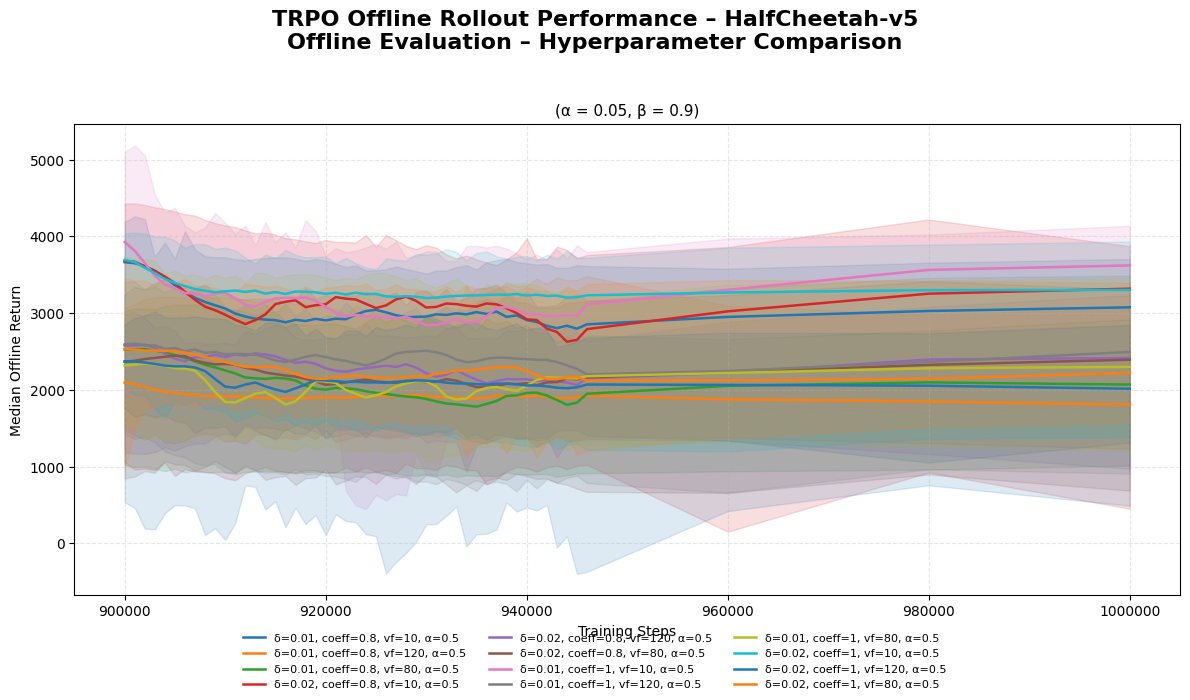

Found 128 PPO offline logs.
Found 16 unique PPO configs with offline evaluations.

📊 PPO Offline Evaluation Ranking – HalfCheetah-v5

Config                          Median≥900k Std≥900k Mean/Std
clip=0.2, kl=0.01, pi=10, vf=20 3,827.03     92.47   41.39   
clip=0.2, kl=0.01, pi=20, vf=20 3,635.14    130.17   27.93   
clip=0.3, kl=0.01, pi=10, vf=10 3,529.10    127.39   27.70   
clip=0.3, kl=0.02, pi=20, vf=20 3,371.46    181.85   18.54   
clip=0.2, kl=0.02, pi=10, vf=20 3,354.76    166.39   20.16   
clip=0.3, kl=0.01, pi=20, vf=10 3,345.69     99.91   33.49   
clip=0.2, kl=0.01, pi=20, vf=10 3,246.81     90.11   36.03   
clip=0.2, kl=0.02, pi=20, vf=10 3,236.58    133.93   24.17   
clip=0.3, kl=0.02, pi=20, vf=10 3,061.69    329.56    9.29   
clip=0.2, kl=0.02, pi=10, vf=10 3,041.46     76.02   40.01   
clip=0.3, kl=0.02, pi=10, vf=10 2,954.05    104.76   28.20   
clip=0.2, kl=0.02, pi=20, vf=20 2,843.14     85.86   33.11   
clip=0.3, kl=0.01, pi=20, vf=20 2,616.64    176.65   14.81  

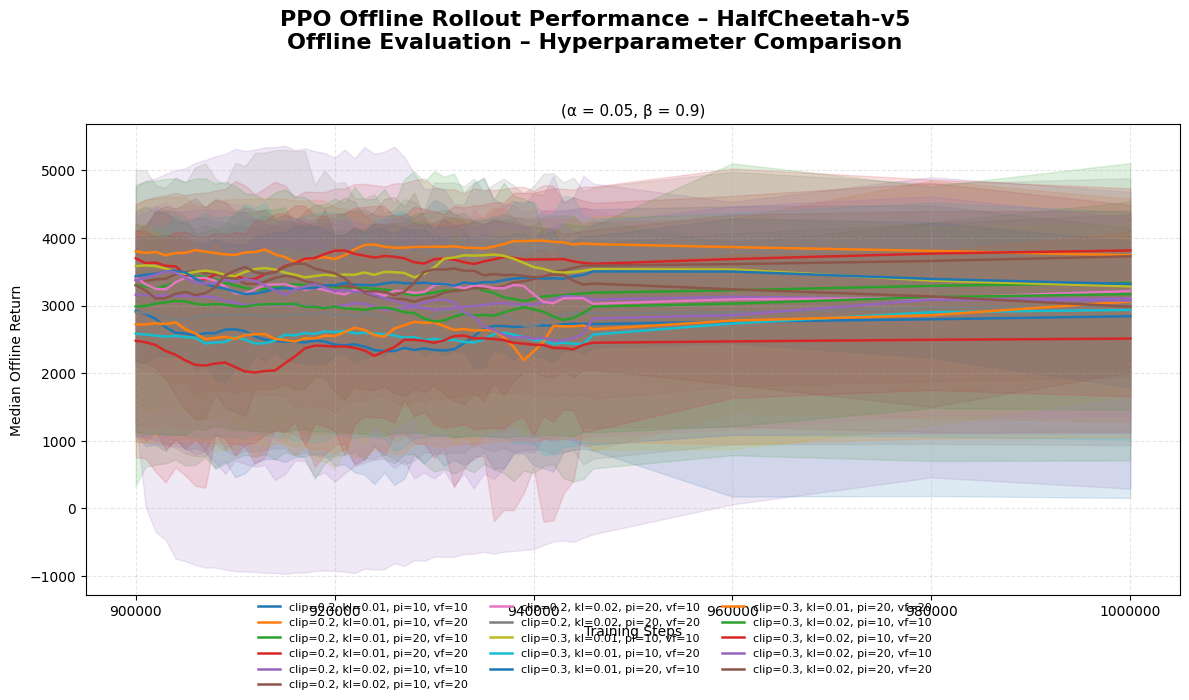

Found 96 TRPO offline logs.
Found 12 unique TRPO configs with offline evaluations.

📊 TRPO Offline Evaluation Ranking – Ant-v5

Config                           Median≥900k Std≥900k Mean/Std
   δ=0.01, coeff=1, vf=10, α=0.5 1,287.31    21.52    59.82   
 δ=0.02, coeff=0.8, vf=10, α=0.5 1,250.01    19.34    64.63   
 δ=0.01, coeff=0.8, vf=10, α=0.5 1,186.93    24.66    48.14   
   δ=0.02, coeff=1, vf=10, α=0.5 1,168.10    53.11    21.99   
 δ=0.01, coeff=0.8, vf=80, α=0.5   880.66    16.75    52.57   
δ=0.01, coeff=0.8, vf=120, α=0.5   776.63    25.38    30.60   
   δ=0.01, coeff=1, vf=80, α=0.5   744.33    19.39    38.40   
 δ=0.02, coeff=0.8, vf=80, α=0.5   734.04    17.46    42.04   
  δ=0.01, coeff=1, vf=120, α=0.5   733.56    21.32    34.41   
δ=0.02, coeff=0.8, vf=120, α=0.5   691.95    25.90    26.71   
   δ=0.02, coeff=1, vf=80, α=0.5   669.69    20.71    32.33   
  δ=0.02, coeff=1, vf=120, α=0.5   461.93    13.05    35.41   
💾 Saved figure to: \\?\\C:\Users\Phong\OneDrive\Docum

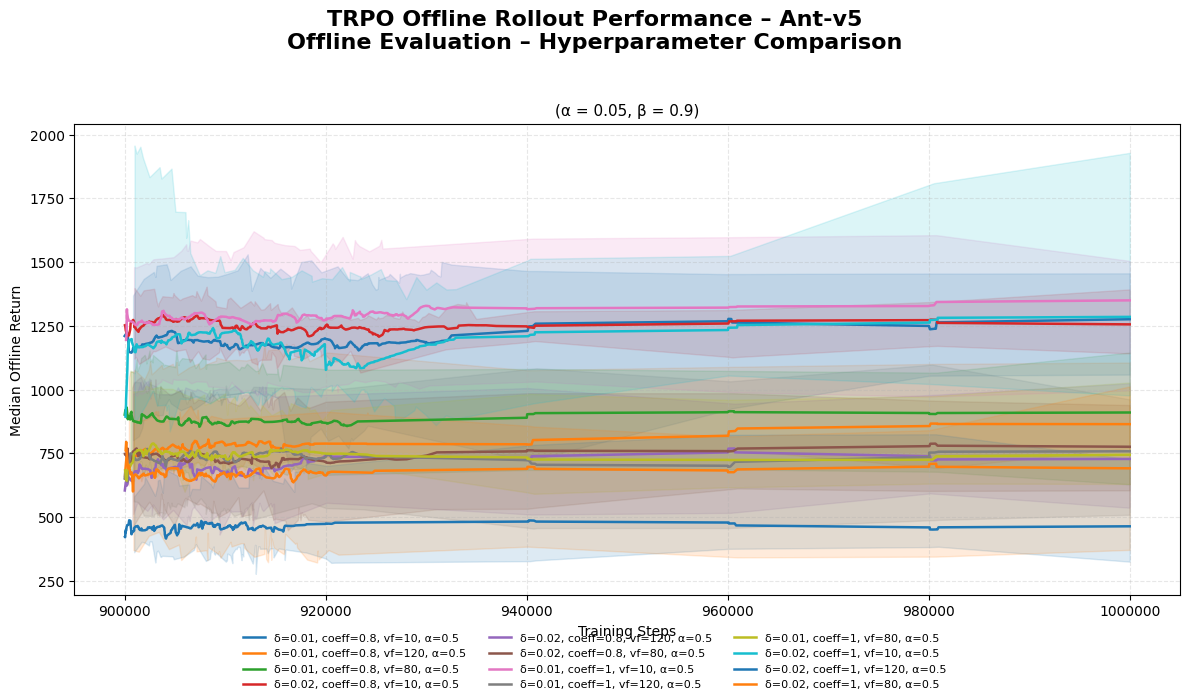

Found 128 PPO offline logs.
Found 16 unique PPO configs with offline evaluations.

📊 PPO Offline Evaluation Ranking – Ant-v5

Config                          Median≥900k Std≥900k Mean/Std
clip=0.3, kl=0.02, pi=10, vf=10 1,802.05    48.82    36.91   
clip=0.3, kl=0.01, pi=20, vf=10 1,692.14    34.49    49.06   
clip=0.3, kl=0.01, pi=10, vf=10 1,685.01    23.38    72.07   
clip=0.2, kl=0.01, pi=20, vf=10 1,679.83    53.05    31.67   
clip=0.3, kl=0.02, pi=10, vf=20 1,654.72    43.42    38.11   
clip=0.3, kl=0.02, pi=20, vf=20 1,620.02    46.01    35.21   
clip=0.3, kl=0.02, pi=20, vf=10 1,584.14    46.23    34.26   
clip=0.2, kl=0.01, pi=10, vf=10 1,542.85    39.19    39.37   
clip=0.2, kl=0.01, pi=20, vf=20 1,541.69    42.11    36.61   
clip=0.2, kl=0.01, pi=10, vf=20 1,538.63    26.87    57.26   
clip=0.2, kl=0.02, pi=20, vf=10 1,493.84    55.43    26.95   
clip=0.2, kl=0.02, pi=10, vf=10 1,460.52    57.58    25.36   
clip=0.2, kl=0.02, pi=20, vf=20 1,459.23    28.39    51.40   
clip=0

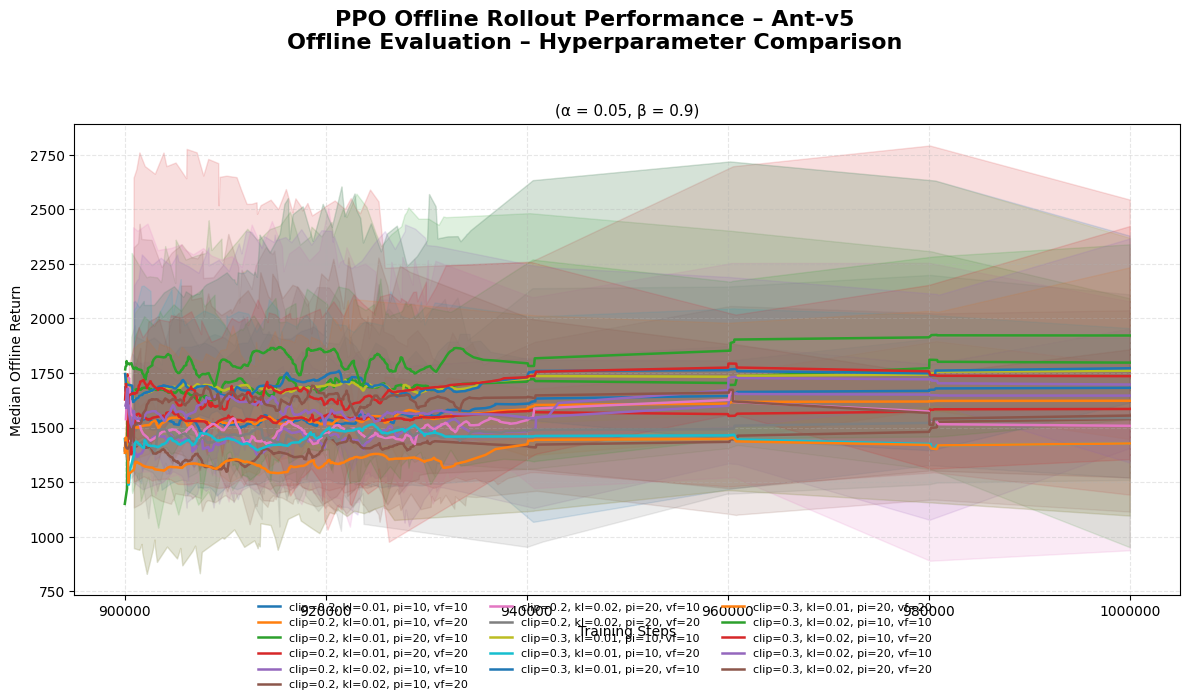

In [3]:
# HalfCheetah-v5
df_trpo_off_chet, curves_trpo_off_chet = analyze_trpo_offline_logs(
    log_dir=r"C:/Users/Phong/OneDrive/Documents/VSCODEFILE/CMPUT665-PROJECT/trpo_chet",
    env_name="HalfCheetah-v5",
    subtitle="Offline Evaluation – Hyperparameter Comparison",
    save_fig=True,
)

df_ppo_off_chet, curves_ppo_off_chet = analyze_ppo_offline_logs(
    log_dir=r"C:/Users/Phong/OneDrive/Documents/VSCODEFILE/CMPUT665-PROJECT/ppo_chet",
    env_name="HalfCheetah-v5",
    subtitle="Offline Evaluation – Hyperparameter Comparison",
    save_fig=True,
)

# Ant-v5
df_trpo_off_ant, curves_trpo_off_ant = analyze_trpo_offline_logs(
    log_dir=r"C:/Users/Phong/OneDrive/Documents/VSCODEFILE/CMPUT665-PROJECT/trpo_ant",
    env_name="Ant-v5",
    subtitle="Offline Evaluation – Hyperparameter Comparison",
    save_fig=True,
)

df_ppo_off_ant, curves_ppo_off_ant = analyze_ppo_offline_logs(
    log_dir=r"C:/Users/Phong/OneDrive/Documents/VSCODEFILE/CMPUT665-PROJECT/ppo_ant",
    env_name="Ant-v5",
    subtitle="Offline Evaluation – Hyperparameter Comparison",
    save_fig=True,
)
